In [4]:
import sys, os
sys.path.append(os.path.abspath('..'))

from dataset import RibFracDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2

context_size = 2

dataset = RibFracDataset(
    root_dir='../data',
    partition='train',
    context_size=context_size,
    patch_original_size=40,
    patch_final_size=256,
    proportion_fracture_in_patch=0.1,
    level=400,
    window=1800,
    threshold=0.35,
    test_stride=20,
    mean_val=0.5,
    std_val=0.5,
    force_data_info=False,
    debug=True,
)
sampler = dataset.get_train_sampler(seed=0)

batch_size = 4
dataloader = DataLoader(
    dataset=dataset,
    sampler=sampler,
    batch_size=batch_size,
)
iter_dataloader = iter(dataloader)

In [4]:
sum = 0
for i in range(100):
    t1 = time.time()
    batch = next(iter_dataloader)
    t2 = time.time()
    sum += t2 - t1
total = (sum / 100) / batch_size
print('Average time per sample patch: {:.4f}s'.format(total))

Fracture slices: 5526
Non-fracture slices: 5526
Average time per sample patch: 0.0282s


Fracture slices: 12593
Non-fracture slices: 12593


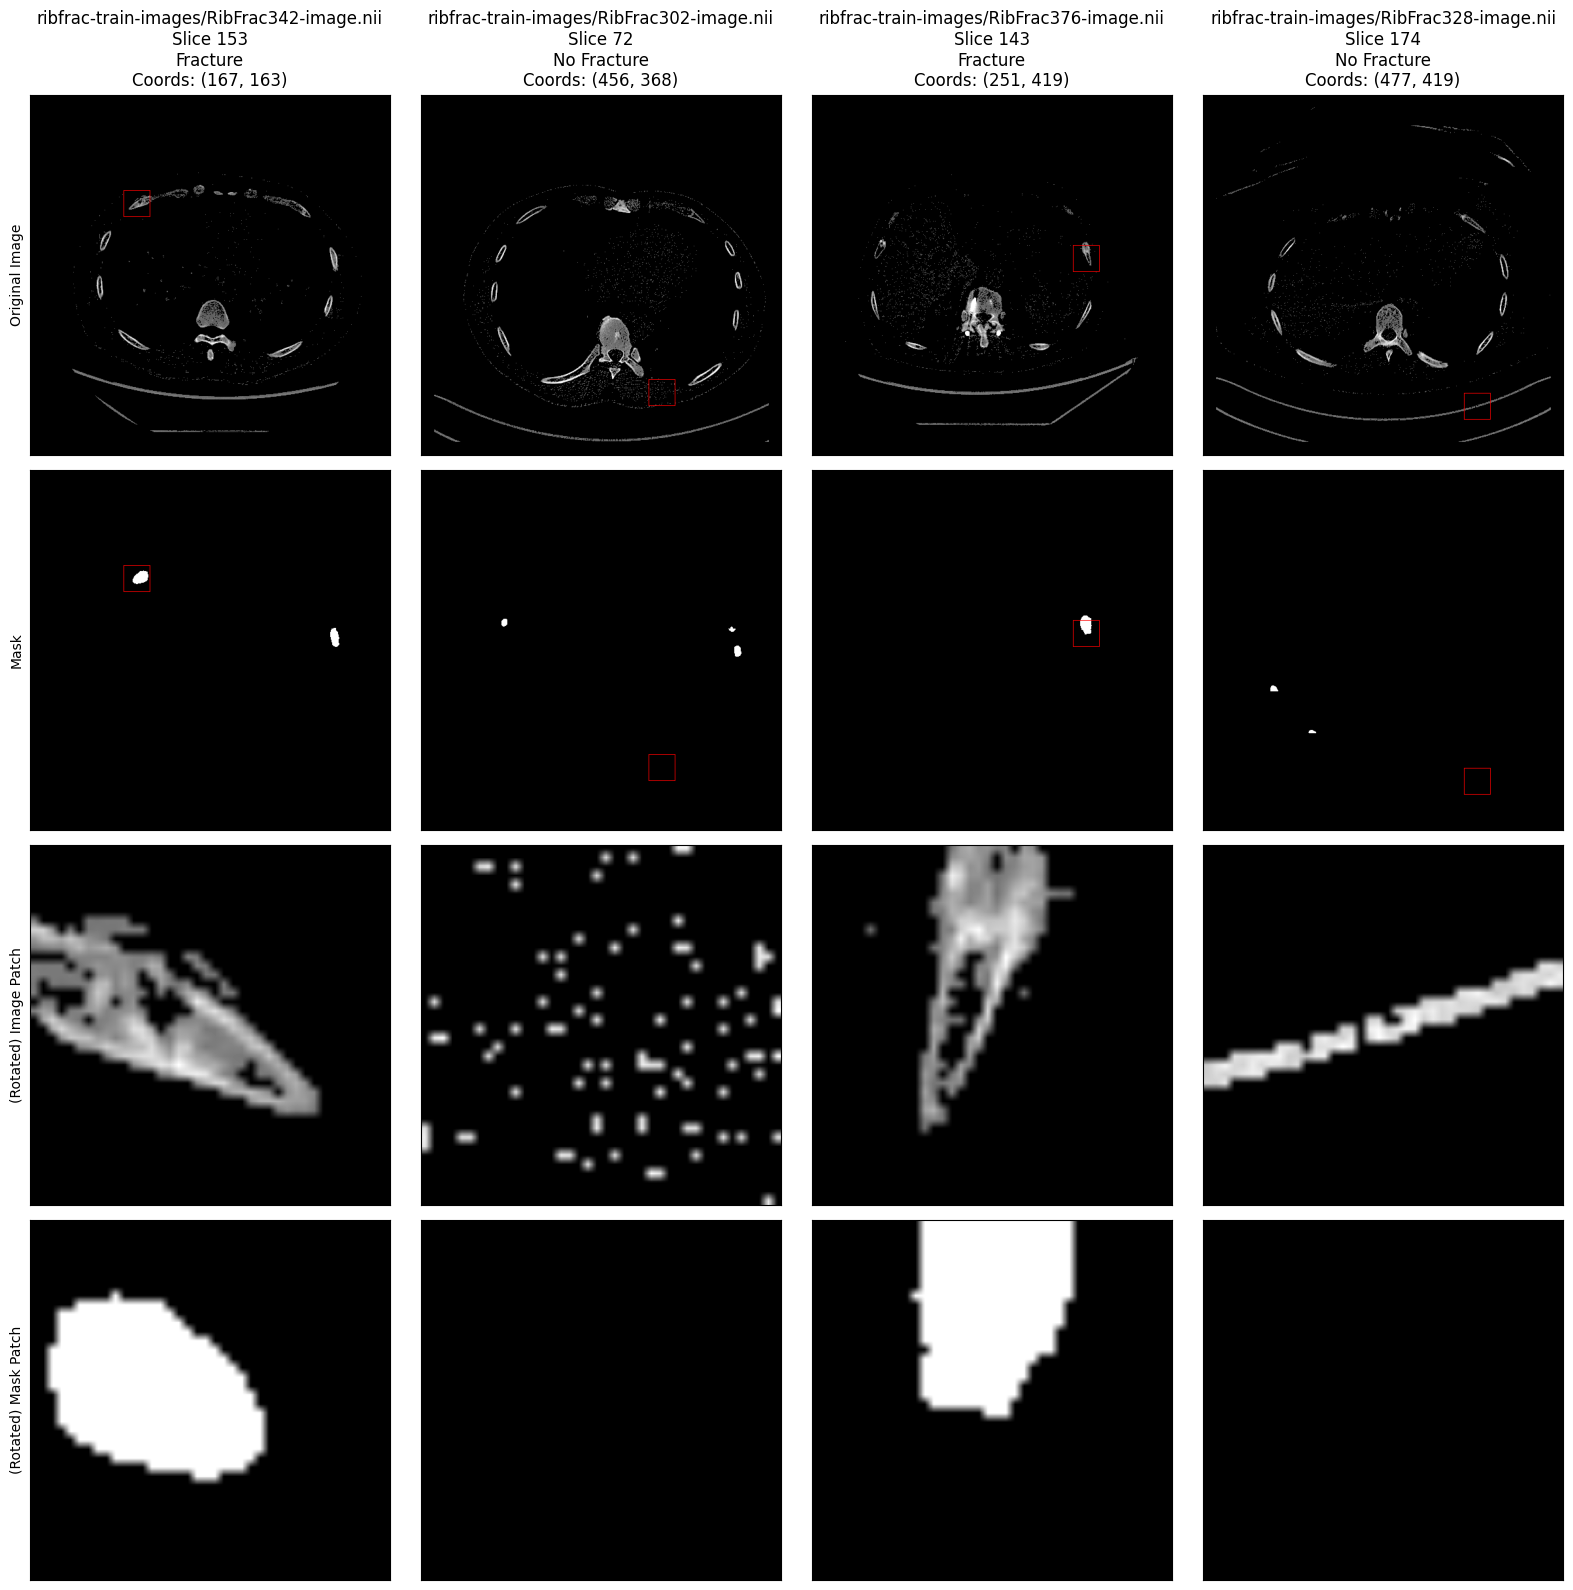

In [5]:
img_patches, label_patches, random_coords, imgs, masks, filenames, slice_idx, is_fracs = next(iter_dataloader)

def draw_rectangle(img, coord):
    img = (np.stack((img, img, img), axis=-1) * 255).astype(np.uint8)
    w = dataset.patch_original_size//2
    start = (int(coord[1] - w), int(coord[0] - w))
    end = (int(coord[1] + w), int(coord[0] + w))
    img = cv2.rectangle(img, start, end, (255, 0, 0), 1)
    return img

f, axes = plt.subplots(4, batch_size, figsize=(batch_size * 4, 16))
for i, (imp, lbp, c, im, lb, f, s, is_f) in enumerate(zip(img_patches, label_patches, random_coords, imgs, masks, filenames, slice_idx, is_fracs)):
    im = draw_rectangle(im[context_size, :, :].numpy(), c)
    lb = draw_rectangle(lb[0, :, :].numpy(), c)
    axes[0, i].imshow(im)
    axes[1, i].imshow(lb)
    axes[2, i].imshow(imp[context_size, :, :].numpy(), cmap='gray')
    axes[3, i].imshow(lbp[0, :, :].numpy(), cmap='gray')
    axes[0, i].set_title(f'{f}\nSlice {s}\n{"Fracture" if is_f else "No Fracture"}\nCoords: ({c[0]}, {c[1]})')
    for j in range(4):
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])
axes[0, 0].set_ylabel('Original Image')
axes[1, 0].set_ylabel('Mask')
axes[2, 0].set_ylabel('(Rotated) Image Patch')
axes[3, 0].set_ylabel('(Rotated) Mask Patch')
plt.tight_layout()
plt.show()